In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import regionmask
import pandas as pd
from datetime import datetime, timedelta

In [3]:
ds_delta = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_sustained/EAS/OutputDir/GEOSChem.AerosolMass.201601*', combine = 'by_coords')

In [4]:
ds_base = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_base/CEDS/OutputDir/GEOSChem.AerosolMass.201601*', combine = 'by_coords')

In [5]:
ds_emisbase = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_base/CEDS/OutputDir/HEMCO_diagnostics.201601*', combine = 'by_coords')

In [6]:
ds_emispulse = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_sustained/EAS/OutputDir/HEMCO_diagnostics.201601*.nc', combine = 'by_coords')

In [7]:
ds_conc2x = xr.open_mfdataset('../GCrundirs/IRF_runs/BC_sustained/EAS/OutputDir/GEOSChem.AerosolMass.201601*.nc4', combine = 'by_coords')
ds_emis2x = xr.open_mfdataset('../GCrundirs/IRF_runs/BC_sustained/EAS/OutputDir/HEMCO_diagnostics.201601*', combine = 'by_coords')

In [2]:
#old cells

In [2]:
month = 'jan'
month_num = '01'

In [3]:
ds_delta = xr.open_mfdataset(f'../GCrundirs/IRF_runs/pulse_{month}_BC/OutputDir/GEOSChem.AerosolMass.2016*', combine = 'by_coords')

In [4]:
ds_base = xr.open_mfdataset(f'../GCrundirs/IRF_runs/base_{month}_BC/OutputDir/GEOSChem.AerosolMass.2016*', combine = 'by_coords')

In [5]:
ds_emisbase = xr.open_mfdataset(f'../GCrundirs/IRF_runs/base_{month}_BC/OutputDir/HEMCO_diagnostics.2016*', combine = 'by_coords')

In [6]:
ds_emispulse = xr.open_mfdataset(f'../GCrundirs/IRF_runs/pulse_{month}_BC/OutputDir/HEMCO_diagnostics.2016*.nc', combine = 'by_coords')

In [7]:
ds_conc2x = xr.open_mfdataset('../GCrundirs/IRF_runs/2x_jan_BC/OutputDir/GEOSChem.AerosolMass.2016*.nc4', combine = 'by_coords')
ds_emis2x = xr.open_mfdataset('../GCrundirs/IRF_runs/2x_jan_BC/OutputDir/HEMCO_diagnostics.2016*', combine = 'by_coords')

In [8]:
height = pd.read_excel('gc_altitude.xlsx')

In [9]:
height_ds = height.diff().dropna().to_xarray().rename({'index':'lev'})
height_ds['lev'] = ds_base['lev']
height_ds = height_ds.rename({'altitude':'dz'}) 
height_ds['dz']*=1e3


In [10]:
ds_emisbase = xr.merge([ds_emisbase, height_ds], join = 'inner')
ds_emispulse = xr.merge([ds_emispulse, height_ds], join = 'inner')
ds_base = xr.merge([ds_base, height_ds], join = 'inner')
ds_delta = xr.merge([ds_delta, height_ds], join = 'inner')
ds_conc2x = xr.merge([ds_conc2x, height_ds], join = 'inner')
ds_emis2x = xr.merge([ds_emis2x, height_ds], join = 'inner')

In [11]:
def combine_BC(ds):
    sec_day = 86400
    ds['EmisBC_Total'] = (ds['EmisBCPI_Total'] + ds['EmisBCPO_Total'])
    ds['EmisBC_Total'].attrs = {'full_name':'total black carbon','units':'kg/m2/day'}
    ds['EmisBC_Total'] *=sec_day

In [12]:
sec_day = 86400

In [13]:
datasets = [ds_emispulse, ds_emisbase, ds_base, ds_delta, ds_conc2x, ds_emis2x]

In [14]:
for ds in [ds_emispulse, ds_emisbase,ds_emis2x]:
    combine_BC(ds)

## Recreate Doubled Concentration

In [15]:
def global_w_mean(ds, variable):
    return (ds[variable].weighted(ds['AREA']*ds['dz']).mean(dim = ['lat','lon','lev']))

In [16]:
f = (global_w_mean(ds_emis2x, 'EmisBC_Total') - global_w_mean(ds_emisbase, 'EmisBC_Total'))
f= f.assign_coords(time = np.arange(0,len(f['time']))) #inputting a x2 until we get our doubled emissions as daily data
G = (global_w_mean(ds_delta, 'AerMassBC') - 
     global_w_mean(ds_base, 'AerMassBC'))
G = G.assign_coords(time = np.arange(0,len(G['time'])))

f0 = (global_w_mean(ds_emispulse, 'EmisBC_Total') - 
      global_w_mean(ds_emisbase, 'EmisBC_Total')).isel(time = 0)

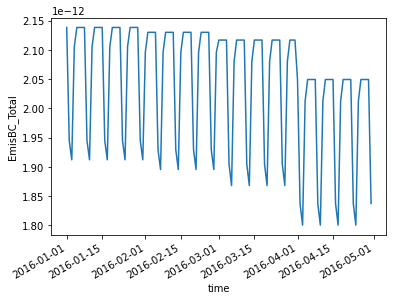

In [82]:
(global_w_mean(ds_emis2x, 'EmisBC_Total') - global_w_mean(ds_emisbase, 'EmisBC_Total')).plot()

```python
f = [1,2,3]
G = [1, 0.5, 0.25, 0.01]

plt.plot([t[0], t[1], t[2]], [f[0]*G[i].values*dt for i in [0, 1, 2]])
plt.plot([t[0], t[1], t[2]], [f[0]*G[i+1].values*dt for i in [0, 1, 2]] + [f[1]*G[i].values*dt for i in [0, 1, 2]])  
```

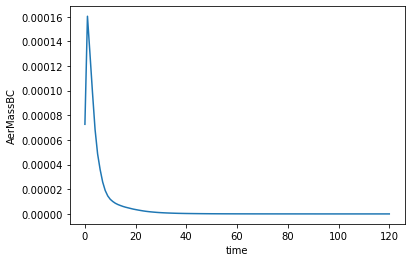

In [17]:
G.plot()

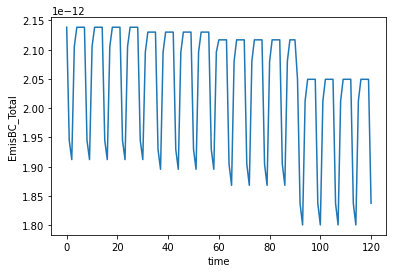

In [84]:
f.plot()

In [19]:
def f_(raw_f, t_p): 
    return raw_f.interp({'time':t_p})

In [20]:
def G_(GC_out, t, t_p, f_0, Δt):
    'where G(t-t_p) such that t-t_p = s), if s<0, the function goes to 0'
    s = t-t_p
    if t>t_p:
        G = GC_out.interp({'time':s}).values/( Δt*f_0.values) #divide by our original f0 and our dt in order to get into units of concentration
    elif t_p>=t:
        G = 0 #np.nan
        
    return(G)

In [21]:
def G_f_kernel(raw_G, raw_f, t, t_p, Δt, dt, f_0):
    'where C(t) = int[G(t-t_p)f(t_p)]dt and t_p is the midpoint of the integral (eg: if integrating from 2020-2030, it is dt/2 away from 2020)'
    return(G_(raw_G, t, t_p, f_0, Δt)*f_(raw_f, t_p).values*dt)


In [24]:
Ndt = 15
dt = 1 #days
t_range = np.arange(0., dt*Ndt, dt)
Δt = 1


In [25]:
C_df = pd.DataFrame(columns = np.arange(0, len(t_range)), index = t_range)


In [27]:
for i, tp in enumerate(t_range):
    for t in t_range:
        i = int(i)
        C_df[i].loc[t] = G_f_kernel(G, f, t, tp,Δt, dt, f0)
        


In [32]:
C_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.0,0.000011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.000009,0.00001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,0.000007,0.000008,0.00001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,0.000005,0.000006,0.000008,0.000011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,0.000003,0.000004,0.000006,0.000009,0.000011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6.0,0.000002,0.000003,0.000004,0.000007,0.000009,0.000011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7.0,0.000002,0.000002,0.000003,0.000005,0.000007,0.000009,0.000011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8.0,0.000001,0.000002,0.000002,0.000003,0.000005,0.000007,0.000009,0.000011,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9.0,0.000001,0.000001,0.000002,0.000002,0.000003,0.000005,0.000007,0.000009,0.00001,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

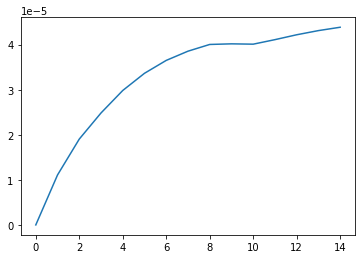

In [33]:
C_df.sum(axis = 1).plot()

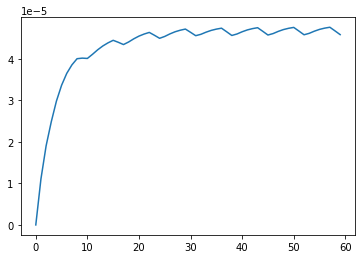

In [95]:
plt.plot(C_df.sum(axis = 1));

#plt.ylim(0,1.2e-9)

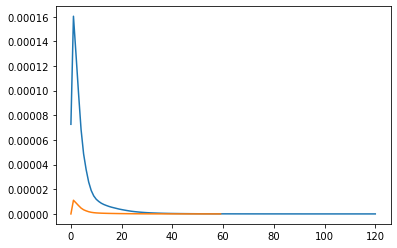

In [96]:
plt.plot(G);
plt.plot(C_df[0])

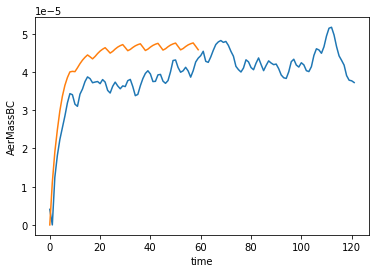

In [97]:
(global_w_mean(ds_conc2x, 'AerMassBC') - global_w_mean(ds_base, 'AerMassBC')).assign_coords(time = np.arange(0,len(ds_base['time']))).plot()
#((C_df.sum(axis = 1)).to_xarray().rename({'index':'time'})).plot(marker = 'o')
plt.plot(C_df.sum(axis = 1));


In [109]:
#(global_w_mean(ds_conc2x, 'AerMassBC') - global_w_mean(ds_base, 'AerMassBC')).assign_coords(time = np.arange(0,len(ds_base['time']))).plot()
C_df.cumsum(axis = 1).plot()
plt.legend('')

AttributeError: 'numpy.float64' object has no attribute 'plot'

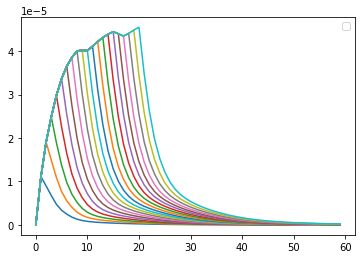

In [118]:
C_df.cumsum(axis = 1)[C_df.cumsum(axis = 1).columns[0:20]].plot()
plt.legend('')

In [ ]:
df[df.columns[1:4]]